# Assignment - 1 EE5179 
## by (EE21S061)

First We need to import some important packages and libraries and then download the MNIST dataset.

In [1]:
# import torch
# import torchvision
import torchvision.datasets as datasets
import numpy as np

c:\users\ariha\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Given Below are the transform function which we will be applying to the dataset to change the labels from a number to one hot encoding this is done as the label are categories and not a continous variable.
* Another function is to normalize the image to (0,1) from (0,255) to make it easier for the model to process.

In [2]:

def one_hot(x):
    temp = np.zeros(10, dtype=float)
    temp[x] = 1
    return temp

def transform(x):
    return np.array(x)/255.0

In [3]:

mnist_trainset = datasets.MNIST(root='./data', train = True , download=True, transform=transform, target_transform = one_hot)
mnist_testset = datasets.MNIST(root='./data', train = False ,download=True, transform=transform, target_transform = one_hot)


### Loading the data and visualizing it 

Text(0.5, 1.0, 'image index 10 label 3')

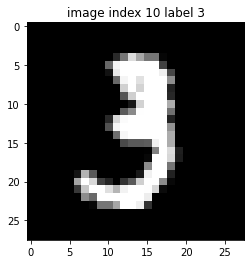

In [4]:
import matplotlib.pyplot as plt
i=10
plt.imshow(mnist_trainset.data[i],cmap='gray')
plt.title("image index " + str(i) + " label " + str(mnist_trainset.targets[i].item()) )

Importing Dataloader from the torch library to make batch of data to pass to the model to train on.

In [5]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mnist_testset, batch_size=64, shuffle=True)

* Dataloader returns us a list of 938 element where each element has 64 samples except the last which contains the remaining 32 to sum up to 60000

In [6]:
len(train_dataloader)

938

## Writing all the necessary function to train the model:

### function defination:

* Intialize Parameter: Initiliaze parameter for a given no. of layer and their neurons. Takes in an argument to intialize according to glorot, random or zeros.

* forward pass : Passes the x through the weights and biases to generate output and then returns the intermediate computation as cache.

* back_prop : Computes the gradient for the back propagation given the ground truth and predicted output.

* Update Parameter : Updates paramerter receives grads and learning rate and also regularization parameter for L2 Regularization and then computes the new updated weights accordingly.

* Compute Cost : Compute Cross entropy cost for the given prediction and ground truth.

In [ ]:
IP_L = mnist_trainset.data[i].flatten().shape[0]
H1_L = 500
H2_L = 250
H3_L = 100
OP_L = mnist_trainset.train_labels.unique().shape[0]

layers_dims = [IP_L,H1_L,H2_L,H3_L,OP_L]
from scipy.special import softmax

def initialize_parameters(layer_dims,initial):
    
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        
        if initial == "glorot":
            M = np.sqrt(6*(1/(layer_dims[l]+layer_dims[l-1])))
            parameters['W' + str(l)] = np.random.uniform(low = -M, high = M, size = (layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        elif initial == "random":
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
            
        else:
            parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
            
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters
    
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0,x)


def forward_pass(img,parameters,function):
    
    forward_pass = {}
    L = int (len(parameters)/2)
    
    forward_pass['Z1'] = ( np.dot(parameters['W1'],img) + (parameters['b1']) )
    
    for i in range(2,L+1):
        
        forward_pass['A' + str(i-1)] =(function(forward_pass['Z' + str(i-1)]))
        forward_pass['Z' + str(i)] =( np.dot(parameters['W'+ str(i)],forward_pass['A' + str(i-1)]) + (parameters['b' + str(i)]) )
        
    forward_pass['A' + str(L)] = (softmax(forward_pass['Z' + str(L)],axis = 0))
    
    cache = (forward_pass,parameters)
    
    return forward_pass['A' + str(L)],cache

def back_prop(X,Y,cache):
    
    m = X.shape[1]
    
    forward_pass,parameters = cache
    L = len(parameters)//2
    
    grads = {}
    
    grads['dZ' + str(L)] = forward_pass['A' + str(L)] - Y
    
    
    for i in range(L-1,0,-1):
        
        grads['dW' + str(i+1)] = 1./m * np.dot(grads['dZ' + str(i+1)],forward_pass['A' + str(i)].T)
        grads['db' + str(i+1)] = 1./m * np.sum(grads['dZ' + str(i+1)],axis=1,keepdims = True)
        grads['dA' + str(i)] = np.dot(parameters['W' + str(i+1)].T,grads['dZ' + str(i+1)])
        grads['dZ' + str(i)] = grads['dA' + str(i)]*forward_pass['A' + str(i)]*(1-forward_pass['A' + str(i)])
    
    grads['dW1'] = 1./m * np.dot(grads['dZ1'],X.T)
    grads['db1'] = 1./m * np.sum(grads['dZ1'],axis=1,keepdims = True)

    return grads


def update_parameters(parameters,grads,learning_rate,lambd = 0):
    
    L = len(parameters)//2
    
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - (learning_rate * grads["dW" + str(k+1)] + lambd*parameters["W" + str(k+1)])
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - (learning_rate * grads["db" + str(k+1)])
        
    return parameters

def compute_cost(a3 , Y):
    
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.sum(logprobs)
    
    return cost

## Testing the above function without Training to verify all the functionality.

In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))

train_X = np.swapaxes(np.array(train_features),0,2).reshape(784,64)
train_Y = np.swapaxes(np.array(train_labels),0,1)
parameters = initialize_parameters(layers_dims,'glorot')
predict , cache = forward_pass(train_X,parameters,sigmoid)
pass_ = back_prop(train_X,train_Y,cache)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.19137893 0.10790716 0.08516302 0.04884058 0.08718535 0.06537799
 0.04267587 0.18759968 0.12786375 0.05600766]
Prediction  0


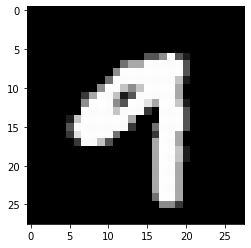

In [10]:
i=10
plt.imshow(np.swapaxes(train_X[:,i].reshape(28,28),0,1),cmap='gray')
print(str(train_Y[:,i]))
print(predict[:,i])
print("Prediction ",np.where(forward_pass(train_X,parameters,sigmoid)[0][:,i] == forward_pass(train_X,parameters,sigmoid)[0][:,i].max())[0][0])

Currently the model is randomly prediting any label since the weights are not optimized and trained.

In [11]:
cache[0].keys()

dict_keys(['Z1', 'A1', 'Z2', 'A2', 'Z3', 'A3', 'Z4', 'A4'])

In [12]:
cache[1].keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'])

In [13]:
pass_.keys()

dict_keys(['dZ4', 'dW4', 'db4', 'dA3', 'dZ3', 'dW3', 'db3', 'dA2', 'dZ2', 'dW2', 'db2', 'dA1', 'dZ1', 'dW1', 'db1'])

In [14]:
train_dataloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mnist_testset, batch_size=64, shuffle=True)

## Given below are function to check accuracy and plot confusion matrix for any model.

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def accuracy(parameter,mnist_testset,function):
    size = mnist_testset.data.shape[0]
    img_size = mnist_testset.data.shape[1] * mnist_testset.data.shape[2]
    
    
    test_dataloader = next(iter(DataLoader(mnist_testset, batch_size=size, shuffle=True)))
    X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size,size)
    
    pred = np.swapaxes(forward_pass(X, parameter,function)[0],0,1)
    Y = np.array(test_dataloader[1])
    
    accuracy = accuracy_score(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
    return accuracy

def confusion_mat(parameter,mnist_testset,function):
    size = mnist_testset.data.shape[0]
    img_size = mnist_testset.data.shape[1] * mnist_testset.data.shape[2]
    
    
    test_dataloader = next(iter(DataLoader(mnist_testset, batch_size=size, shuffle=True)))
    X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size,size)
    
    pred = np.swapaxes(forward_pass(X, parameter,function)[0],0,1)
    Y = np.array(test_dataloader[1])
    
    confu_matrix = confusion_matrix(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
    
    return confu_matrix

In [22]:
print("test " ,accuracy(parameters,mnist_testset,sigmoid))
print("train " ,accuracy(parameters,mnist_trainset,sigmoid))
print("test " ,confusion_mat(parameters,mnist_testset,sigmoid))
print("train " ,confusion_mat(parameters,mnist_trainset,sigmoid))

test  0.1103
train  0.10961666666666667
test  [[ 843    0    0    0    0    0    0  137    0    0]
 [1133    0    0    0    0    0    0    2    0    0]
 [ 764    0    0    0    0    0    0  268    0    0]
 [ 927    0    0    0    0    0    0   83    0    0]
 [ 917    0    0    0    0    0    0   65    0    0]
 [ 881    0    0    0    0    0    0   11    0    0]
 [ 935    0    0    0    0    0    0   23    0    0]
 [ 768    0    0    0    0    0    0  260    0    0]
 [ 950    0    0    0    0    0    0   24    0    0]
 [ 845    0    0    0    0    0    0  164    0    0]]
train  [[5121    0    0    0    0    0    0  802    0    0]
 [6736    0    0    0    0    0    0    6    0    0]
 [4609    0    0    0    0    0    0 1349    0    0]
 [5688    0    0    0    0    0    0  443    0    0]
 [5578    0    0    0    0    0    0  264    0    0]
 [5386    0    0    0    0    0    0   35    0    0]
 [5834    0    0    0    0    0    0   84    0    0]
 [4809    0    0    0    0    0    0 1456    

We can see how it mostly predicts one catergory out of 10 and that gives it an accuracy of 10% just by random guessing lets see how much can we improve.

## Given below is the function to train the model.

* It takes in a Dataloader object which then is looped to go throught the entire dataset.

* After every batch parameters are updated and cost is computed. We are trying to minimize the cost over batches and this can take more than one go epoch.

* Every epoch the dataloader is shuffled and then re-trained.

In [23]:
def model(train_dataloader,batch_size = 64,learning_rate = 0.3, epoch = 10, print_cost = True, lambd = 0,initial = "random",function = sigmoid):
    
    grads = {}
    costs = []
    m = batch_size
    layers_dims = [IP_L, H1_L, H2_L, H3_L,OP_L]
    
    parameters = initialize_parameters(layers_dims,initial)
    count=0
    for i in range(epoch):
        for (batch_idx,batch) in enumerate(train_dataloader):
            batch_x, batch_y = batch
            
            X = np.swapaxes(np.array(batch_x),0,2).reshape(batch_x.shape[1]*batch_x.shape[2],batch_x.shape[0])
            Y = np.swapaxes(np.array(batch_y),0,1)
            a3, cache = forward_pass(X, parameters,function)

            cost = compute_cost(a3, Y)

            grads = back_prop(X, Y, cache)

            parameters = update_parameters(parameters, grads, learning_rate,lambd = lambd)

            if batch_idx % 200 == 0:
                costs.append(cost)
        if print_cost:
            print("Cost after epoch {}: {}".format(i, cost))
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x200)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters,costs

In [24]:
def plotting(parameters,mnist_testset,mnist_trainset):
    test_acc = accuracy(parameters[0],mnist_testset)
    train_acc = accuracy(parameters[0],mnist_trainset)
    conf_matrix = confusion_mat(parameters[0],mnist_testset)
    fig, (ax,bx) = plt.subplots(1,2,figsize=(20, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Iteration (x 200)', fontsize=18)
    plt.ylabel('Cost', fontsize=18)
    label = "Test acc. = " + str(test_acc*100) + ", Train acc. = " + str(train_acc*100) 
    plt.title(label, fontsize=18)
    bx.plot(range(0,len(parameters[1])),parameters[1], label = label)

* I have initialized a dictionary below that keys the model name as keys and its weight and biases as parameter. This way i can evaluate accuracy and metric of each model without having to retrain them.

In [25]:
learned_parameters={}

## 1. Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=zero 



In [ ]:
learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "zero"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

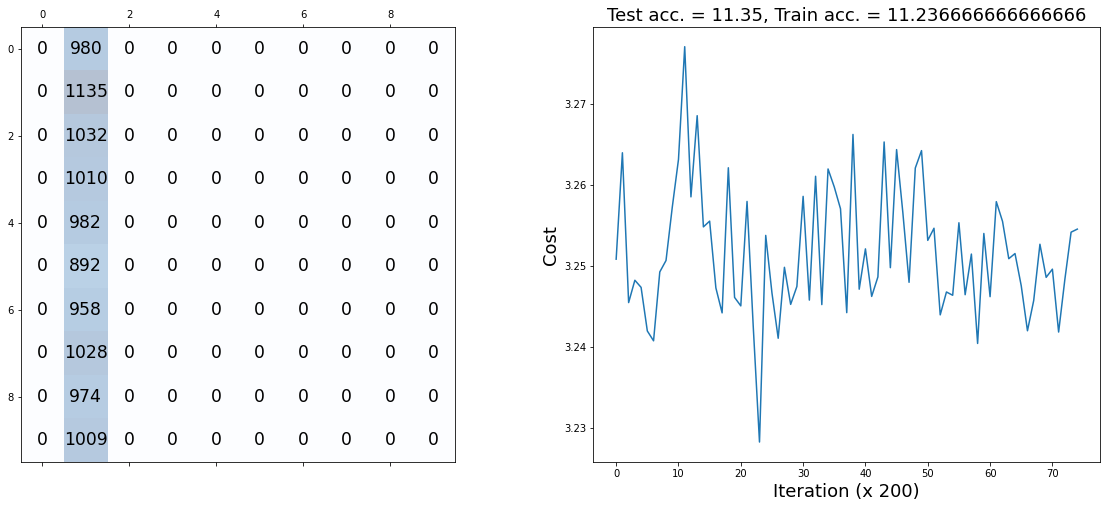

In [231]:
i=list(learned_parameters.keys())[0]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)

* With zero intialization we can see the model is strugling to learn as the weights are all zeros which prevents the gradient to propagate towards the back and then model has a hard time learning.

* The accuracy of the model is just 10% which is what we got with untrained model as well. This model is basically predicting each digit to be 1 and in 1 out of 10 cases it guess right.

## 2. Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=random

## Base model with Random


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=random
Cost after epoch 0: 3.252038908836801
Cost after epoch 1: 3.238409325838771
Cost after epoch 2: 3.226192638972427
Cost after epoch 3: 3.2379100628515545
Cost after epoch 4: 3.1905953621140517
Cost after epoch 5: 3.2006944955462058
Cost after epoch 6: 3.1859836336151304
Cost after epoch 7: 3.084646887060112
Cost after epoch 8: 2.804781169153361
Cost after epoch 9: 2.679422965989632
Cost after epoch 10: 2.2329291723802696
Cost after epoch 11: 2.186817162467591
Cost after epoch 12: 1.94748787227384
Cost after epoch 13: 1.9681613273691436
Cost after epoch 14: 1.8987674571517335


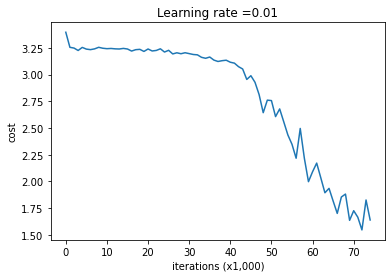

In [29]:
learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "random"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

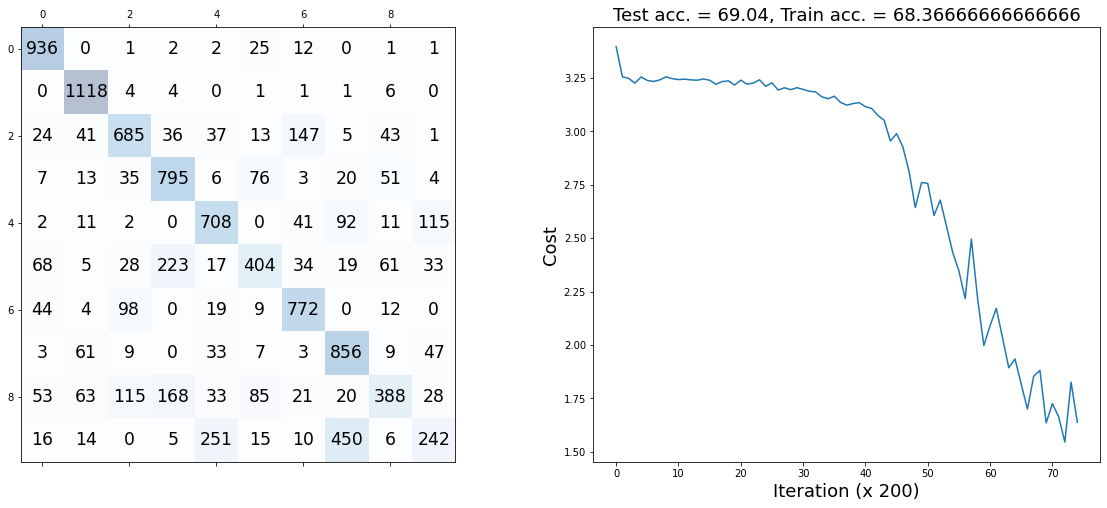

In [232]:
i=list(learned_parameters.keys())[1]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)


* With initialization random we can see how the model is getting better at each iteration but this model also is taking time with a relatively slow learning rate each step is very slightly moving towards a lower cost

* This model is trained and gets to an accuracy of 69 on train dataset and 68 on test dataset which means the model did not overfit or underfit it just could not learn enough because of low learning rate.

* In the confusion matrix we can see how individual digit are being predicted.

* One of the observation digit 4 is being predicted as 9 which makes sense given how those 2 digits look really similar to each other.

## 3. Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=random

## Base model with Glorot



Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=glorot
Cost after epoch 0: 3.199414281236022
Cost after epoch 1: 3.2309661141953256
Cost after epoch 2: 3.18456554629962
Cost after epoch 3: 3.148155650988432
Cost after epoch 4: 3.0716608350434518
Cost after epoch 5: 2.868962563983663
Cost after epoch 6: 2.5077585489660152
Cost after epoch 7: 2.2983109512729274
Cost after epoch 8: 1.855820798883236
Cost after epoch 9: 1.5973805450000325
Cost after epoch 10: 1.4758398857717512
Cost after epoch 11: 1.7866766523612383
Cost after epoch 12: 1.318384844540719
Cost after epoch 13: 1.2188298098723918
Cost after epoch 14: 0.9347466372906299


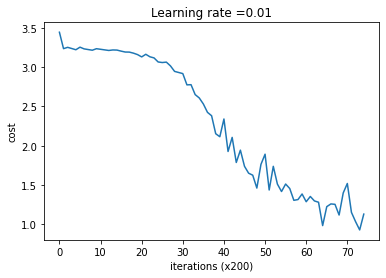

In [32]:
learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

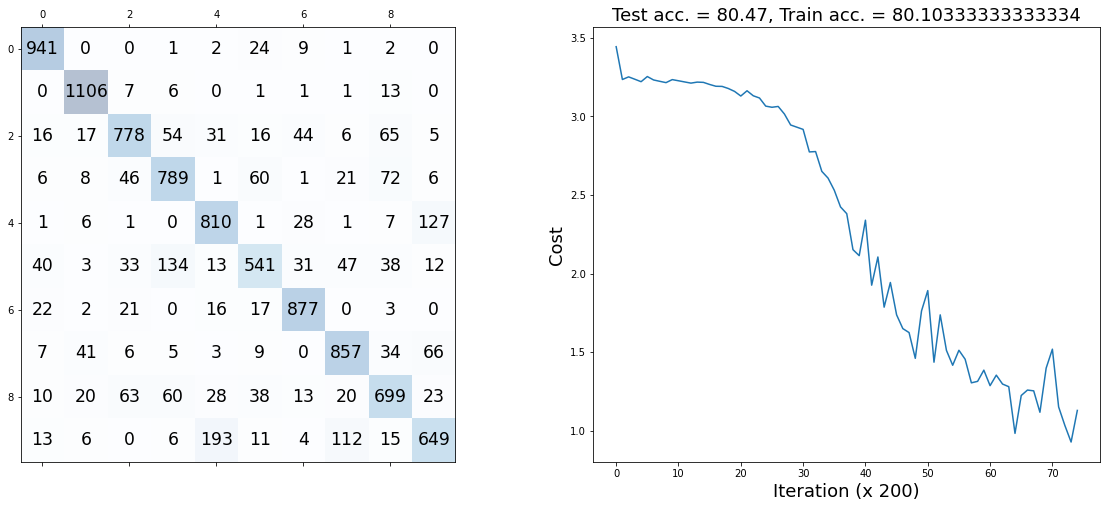

In [36]:
i=list(learned_parameters.keys())[0]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)

* We can see improvement between the random and glorot initialization for all the same hyper parameter.

* We get an accuracy of 80% on test dataset and 80% on train dataset. This is better than random initialization for same number of epoch and learning rate.

## 4. Model Key: Epoch=15,alpha=0.3,Regularization=0,Batch=64,Initilization=random



Model Key: Epoch=15,alpha=0.3,Regularization=0,Batch=64,Initilization=random
Cost after epoch 0: 1.311305421940848
Cost after epoch 1: 0.7376153472129574
Cost after epoch 2: 0.4611833068662473
Cost after epoch 3: 0.14787641851186037
Cost after epoch 4: 0.5569817887064544
Cost after epoch 5: 0.3806666346568692
Cost after epoch 6: 0.34620107811634493
Cost after epoch 7: 0.405159620225043
Cost after epoch 8: 0.14343355831675084
Cost after epoch 9: 0.21602451594849398
Cost after epoch 10: 0.1926831532428831
Cost after epoch 11: 0.021580802453976256
Cost after epoch 12: 0.1590837249818602
Cost after epoch 13: 0.09106780967032568
Cost after epoch 14: 0.16014157926590922


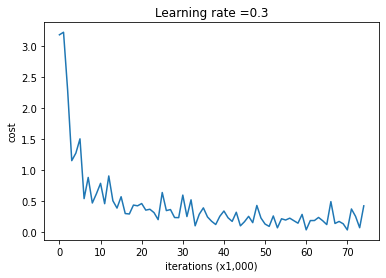

In [31]:
learning_rate = 0.3
lambd = 0
epoch = 15
batch_size = 64
initial = "random"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

* With a increased learning rate the cost drop drastically in the beginning and then continues to level off and then reach a local minima and fluctuates around it. As the cost in the last epoch is 0.16.

* We get finally accuracy upwards of 95% this is really good for the model. 

* Confusion matrix also now tells us the model has learned very well and the off diagonal entries are really low.

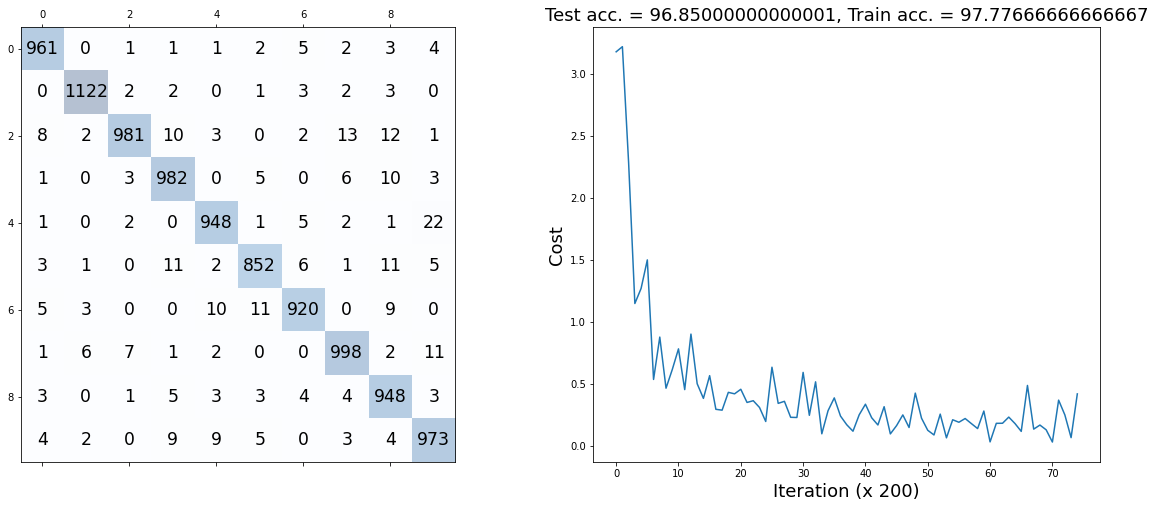

In [233]:
i=list(learned_parameters.keys())[2]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)

## 5. Model Key: Epoch=15,alpha=0.05,Regularization=0,Batch=64,Initilization=random



Model Key: Epoch=15,alpha=0.05,Regularization=0,Batch=64,Initilization=random
Cost after epoch 0: 3.224665213391755
Cost after epoch 1: 2.788050109720024
Cost after epoch 2: 1.1898042048666548
Cost after epoch 3: 1.1406444491985663
Cost after epoch 4: 0.8810634590067951
Cost after epoch 5: 0.908503159352652
Cost after epoch 6: 0.49974415954907686
Cost after epoch 7: 0.793315809578927
Cost after epoch 8: 0.7865468958146927
Cost after epoch 9: 0.5178061356183331
Cost after epoch 10: 0.41017671713944953
Cost after epoch 11: 0.5667719210254194
Cost after epoch 12: 0.43866581391934206
Cost after epoch 13: 0.46264518290771056
Cost after epoch 14: 0.26576831292468994


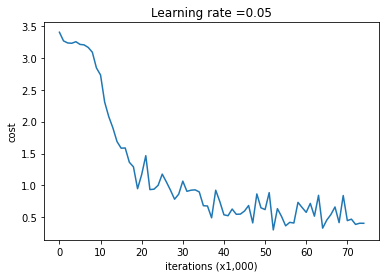

In [51]:
learning_rate = 0.05
lambd = 0
epoch = 15
batch_size = 64
initial = "random"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

* Decreasing the learning rate from 0.3 to 0.05 we can see that we reach similar level of result but the initial drop we observed in the previous graph is now offset from the origin it is taking some time for the cost to drop.

* In same number of epoch we only get 91% accuracy and this is primarily due to decreased learning rate.

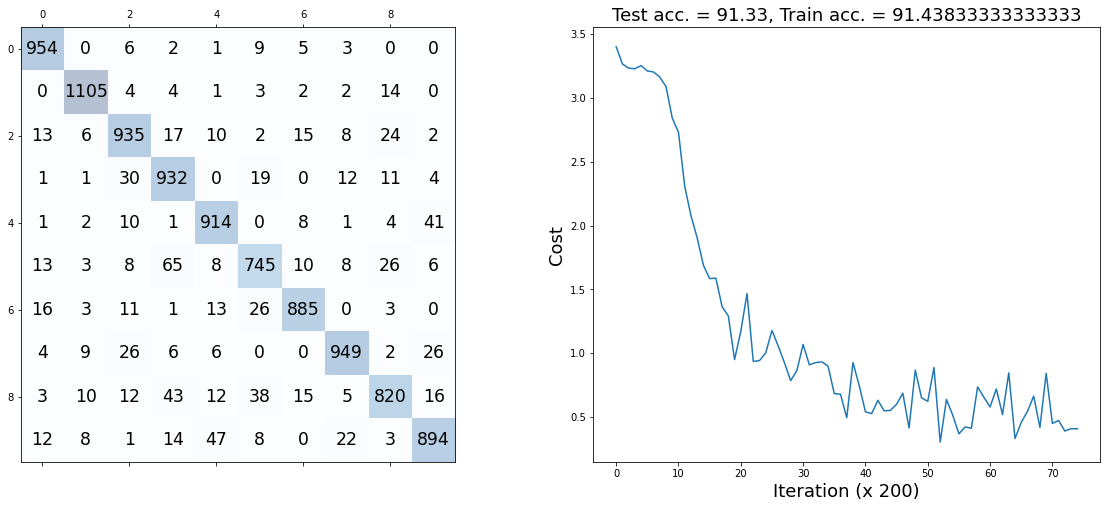

In [234]:
i=list(learned_parameters.keys())[3]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)

## 6. Model Key: Epoch=15,alpha=0.1,Regularization=0,Batch=64,Initilization=random


Model Key: Epoch=15,alpha=0.1,Regularization=0,Batch=64,Initilization=random
Cost after epoch 0: 2.680794921964684
Cost after epoch 1: 1.0084139076956014
Cost after epoch 2: 0.8299404932804902
Cost after epoch 3: 1.205425778287678
Cost after epoch 4: 0.6215709890048675
Cost after epoch 5: 0.8832036326017101
Cost after epoch 6: 0.6584822166953471
Cost after epoch 7: 0.1706529201584267
Cost after epoch 8: 0.8009264709850584
Cost after epoch 9: 0.6785120799548503
Cost after epoch 10: 0.3645161636099311
Cost after epoch 11: 0.5333743525223171
Cost after epoch 12: 0.4177553545600089
Cost after epoch 13: 0.5184256724002205
Cost after epoch 14: 0.38914539931485553


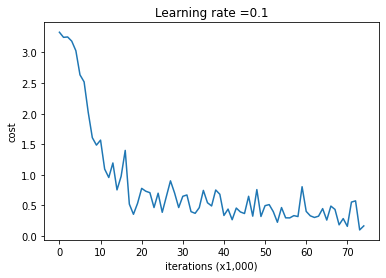

In [52]:
learning_rate = 0.1
lambd = 0
epoch = 15
batch_size = 64
initial = "random"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

* Trying again with a learning rate 0.1 we can see similar behaviour from the this model.

* We can see this one has accuracy improved this means given similar number of epoch we can get better results by varying the learning rate.

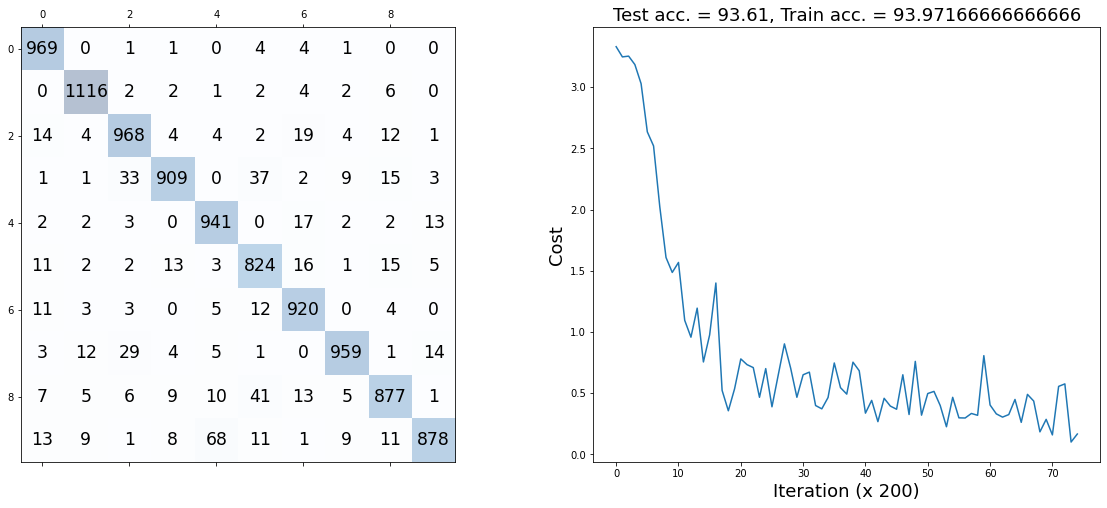

In [235]:
i=list(learned_parameters.keys())[4]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)

## 7. Model Key: Epoch=15,alpha=0.05,Regularization=0,Batch=64,Initilization=glorot
 

In [ ]:
learning_rate = 0.05
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

* This model was initialized using Glorot or xavier initialization which uses a statistical based approach to initialize the weights based on number of neuron in the layers. We can see this allows our model to learn faster even at a learning rate of 0.05

* We get a accuracy of 92 which is very well given the learning rate of 0.05 this is better than random initialization for same learning rate.

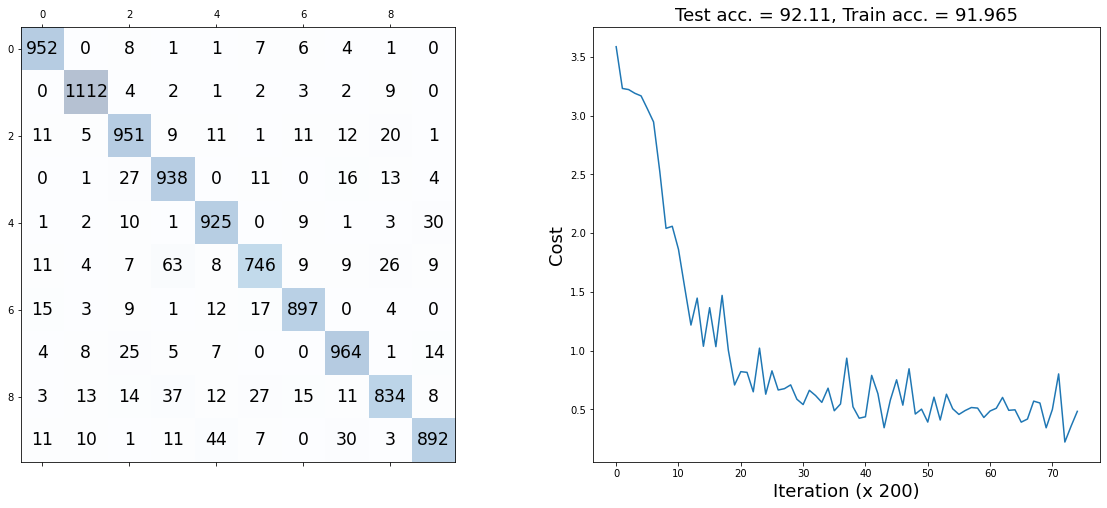

In [236]:
i=list(learned_parameters.keys())[5]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)

## 8. Model Key: Epoch=15,alpha=0.1,Regularization=0,Batch=64,Initilization=glorot



Model Key: Epoch=15,alpha=0.1,Regularization=0,Batch=64,Initilization=glorot
Cost after epoch 0: 1.8002002808462185
Cost after epoch 1: 0.8195788151930303
Cost after epoch 2: 0.5565944973337831
Cost after epoch 3: 0.7540493595031704
Cost after epoch 4: 0.49796052712425115
Cost after epoch 5: 0.681672293546314
Cost after epoch 6: 0.3197477854086318
Cost after epoch 7: 0.3918793457501356
Cost after epoch 8: 0.6587268764778129
Cost after epoch 9: 0.1834088187605184
Cost after epoch 10: 0.19600104581911537
Cost after epoch 11: 0.20311056237992892
Cost after epoch 12: 0.46222009436011924
Cost after epoch 13: 0.5789272819731353
Cost after epoch 14: 0.1296972390642293


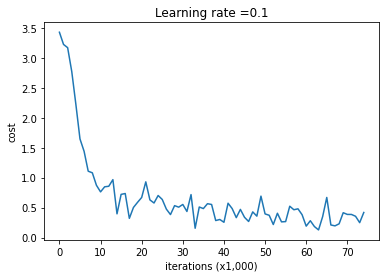

In [77]:
learning_rate = 0.1
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)
learned_parameters[model_name] = model(train_dataloader,batch_size = batch_size,learning_rate = learning_rate, epoch = epoch, print_cost = True, lambd = lambd,initial = initial)

* With a increased learning rate in Glorot initialization the model drops off in cost quite drastically and reaches a minima near 0.12 which is the best we have observed in all the model till now.

* This gives us an accuracy of 94% for a increased learning rate. This is consistent with the result we have seen with random initialization.

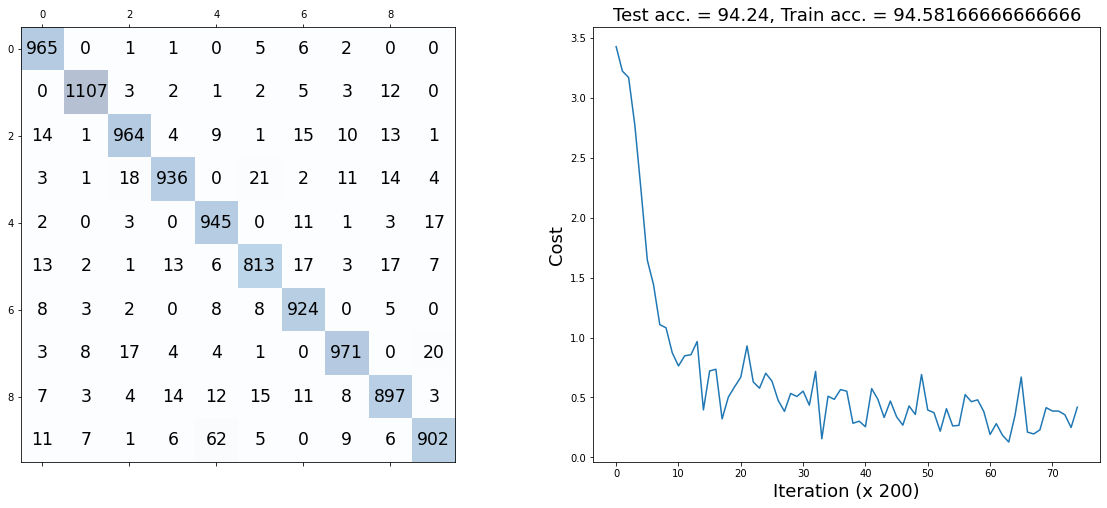

In [237]:
i=list(learned_parameters.keys())[6]
plotting(learned_parameters[i],mnist_testset,mnist_trainset)

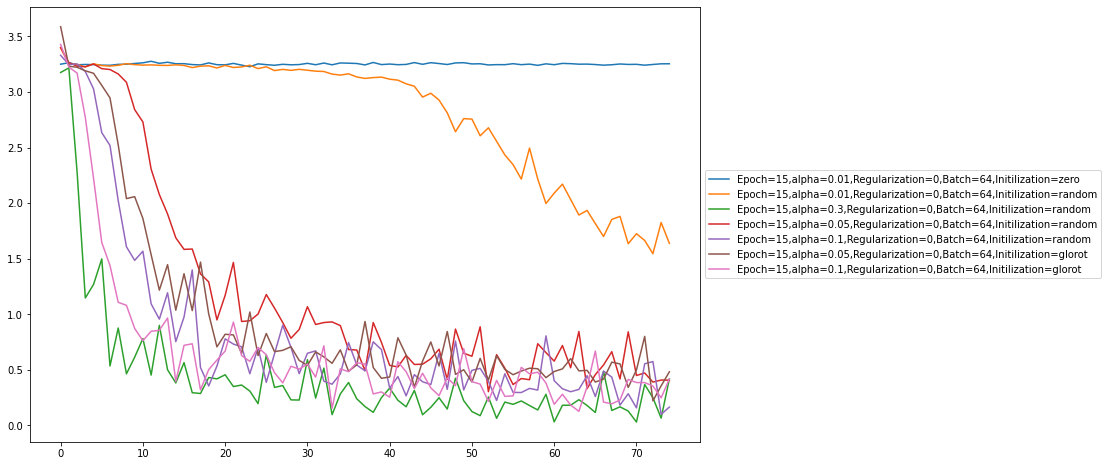

In [95]:
legends = []
plt.figure(figsize=(12,8)) 
for i in learned_parameters.keys():
    plt.plot(range(0,len(learned_parameters[i][1])),learned_parameters[i][1], label = i)
    legends.append(i)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## Plotting all the cost vs interation graph for each model

* All the model starts from a average cost of 3.5.

* Initialization with zero weight is not able to learn at all this is obvious from a consistent cost and a straight line in the graph.

* random weight with learning rate of 0.01 as mentioned in the question gives us a start but we can see the orange line in the graph and how it minimizes the cost but how ineffective it is compared to all the rest of the model i tried.

* All the other model vary with learning rate and initialization.

* All the model have trained for exactly 15 epoch this allows me to compare between the model given same computation time. 

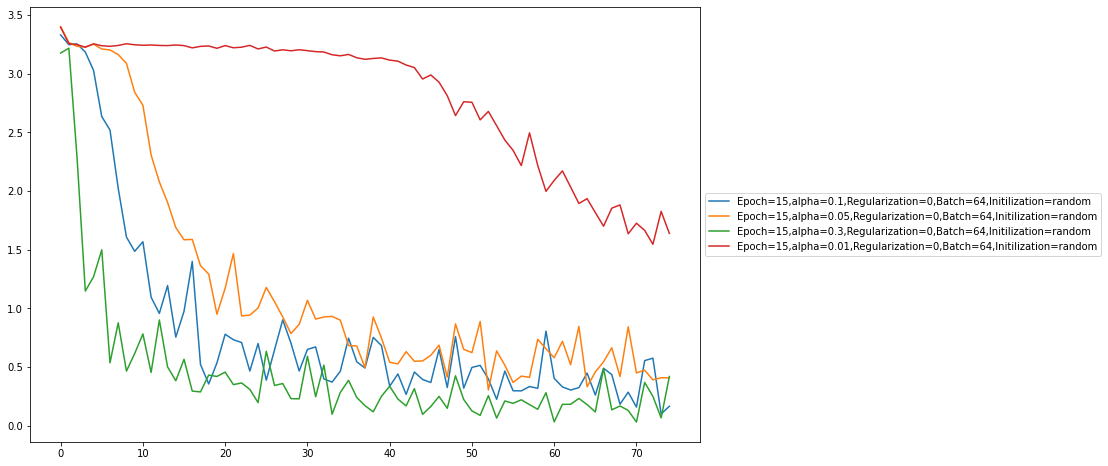

In [99]:

plt.figure(figsize=(12,8)) 
plt.plot(range(0,len(learned_parameters[legends[-3]][1])),learned_parameters[legends[-3]][1], label = legends[-3])
plt.plot(range(0,len(learned_parameters[legends[-4]][1])),learned_parameters[legends[-4]][1], label = legends[-4])
plt.plot(range(0,len(learned_parameters[legends[-5]][1])),learned_parameters[legends[-5]][1], label = legends[-5])
plt.plot(range(0,len(learned_parameters[legends[-6]][1])),learned_parameters[legends[-6]][1], label = legends[-6])    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## All the plot for random initialization 

* All plot here vary in learning rate 

* Red plot is for the learning rate of 0.01 which started to work but took too long and was not able to reach a good result in just 15 epoch.

* All other plot reach a local minima in given time and can improve further given more time.

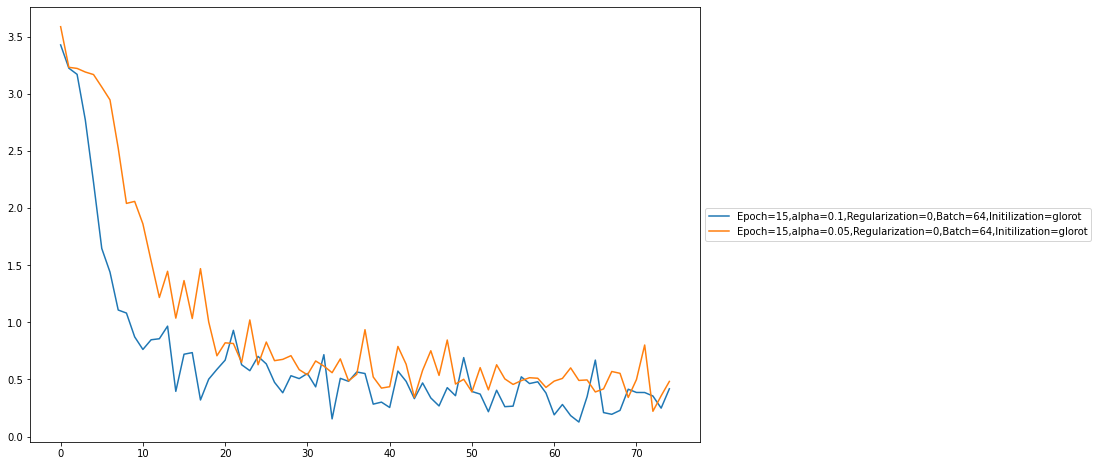

In [98]:

plt.figure(figsize=(12,8)) 
plt.plot(range(0,len(learned_parameters[legends[-1]][1])),learned_parameters[legends[-1]][1], label = legends[-1])
plt.plot(range(0,len(learned_parameters[legends[-2]][1])),learned_parameters[legends[-2]][1], label = legends[-2])    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## All plot for Glorot initialization

* I trained these model on learning rate of 0.1 and 0.05 both of which seems to optimize the weights to a local minima and we get a good model in 15 epoch.

## Now lets try these model with Pytorch

* For this part i will be using pytorch library to train model and here we are going to be using same hyperparameter

In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
input_size = 784 
hidden_size_1 = 500 
hidden_size_2 =250
hidden_size_3 = 100
num_classes = 10
num_epochs = 15
batch_size = 64
learning_rate = 0.01

## Model with tanh as activation function instead of sigmoid

In [64]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1,hidden_size_2,hidden_size_3, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size_1) 
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.tanh = nn.Tanh()
        self.l3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.tanh = nn.Tanh()
        self.l4 = nn.Linear(hidden_size_3, num_classes)
        self.softmax = nn.LogSoftmax(dim = 1) 
    
    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        out = self.l4(out)
        out = self.softmax(out)
        
        return out


model = NeuralNet(input_size, hidden_size_1,hidden_size_2,hidden_size_3, num_classes).to(device)

In [65]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [66]:
# Train the model
loss_log = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_log.append(loss.item())

Epoch [1/15], Step [100/938], Loss: 0.4789
Epoch [1/15], Step [200/938], Loss: 0.3475
Epoch [1/15], Step [300/938], Loss: 0.3771
Epoch [1/15], Step [400/938], Loss: 0.4350
Epoch [1/15], Step [500/938], Loss: 0.2473
Epoch [1/15], Step [600/938], Loss: 0.2854
Epoch [1/15], Step [700/938], Loss: 0.3029
Epoch [1/15], Step [800/938], Loss: 0.3558
Epoch [1/15], Step [900/938], Loss: 0.3207
Epoch [2/15], Step [100/938], Loss: 0.3486
Epoch [2/15], Step [200/938], Loss: 0.2148
Epoch [2/15], Step [300/938], Loss: 0.2780
Epoch [2/15], Step [400/938], Loss: 0.2914
Epoch [2/15], Step [500/938], Loss: 0.3128
Epoch [2/15], Step [600/938], Loss: 0.6452
Epoch [2/15], Step [700/938], Loss: 0.4673
Epoch [2/15], Step [800/938], Loss: 0.4222
Epoch [2/15], Step [900/938], Loss: 0.1914
Epoch [3/15], Step [100/938], Loss: 0.4441
Epoch [3/15], Step [200/938], Loss: 0.2580
Epoch [3/15], Step [300/938], Loss: 0.3882
Epoch [3/15], Step [400/938], Loss: 0.4038
Epoch [3/15], Step [500/938], Loss: 0.5105
Epoch [3/15

Accuracy of the network on the 10000 test images: 88.47666666666667 %


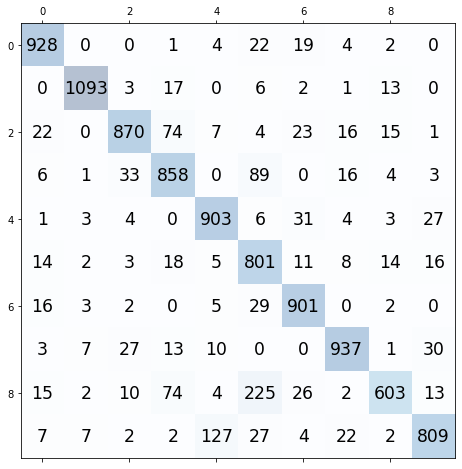

In [84]:
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        y_true.extend(labels.numpy())
        outputs=model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
    cf_matrix = confusion_matrix(y_true, y_pred)
fig,ax = plt.subplots(figsize=(20, 8))
ax.matshow(cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cf_matrix[i, j], va='center', ha='center', size='xx-large')

* Using Tanh as activation function we get 88% as accuracy which is relative to what we got with sigmoid.

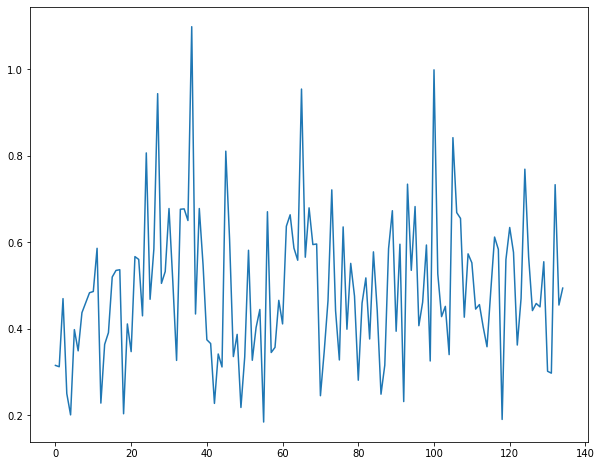

In [82]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

## Model with Relu as activation function

In [89]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1,hidden_size_2,hidden_size_3, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size_1) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)

        self.l3 = nn.Linear(hidden_size_2, hidden_size_3)
        
        self.l4 = nn.Linear(hidden_size_3, num_classes)
        self.softmax = nn.LogSoftmax(dim = 1) 
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.softmax(out)
        
        return out


model = NeuralNet(input_size, hidden_size_1,hidden_size_2,hidden_size_3, num_classes).to(device)

In [90]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
# Train the model
loss_log = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_log.append(loss.item())

Epoch [1/15], Step [100/938], Loss: 0.3840
Epoch [1/15], Step [200/938], Loss: 0.2757
Epoch [1/15], Step [300/938], Loss: 0.5151
Epoch [1/15], Step [400/938], Loss: 0.1739
Epoch [1/15], Step [500/938], Loss: 0.5193
Epoch [1/15], Step [600/938], Loss: 0.2286
Epoch [1/15], Step [700/938], Loss: 0.3819
Epoch [1/15], Step [800/938], Loss: 0.1716
Epoch [1/15], Step [900/938], Loss: 0.1776
Epoch [2/15], Step [100/938], Loss: 0.1696
Epoch [2/15], Step [200/938], Loss: 0.2233
Epoch [2/15], Step [300/938], Loss: 0.0820
Epoch [2/15], Step [400/938], Loss: 0.1587
Epoch [2/15], Step [500/938], Loss: 0.0899
Epoch [2/15], Step [600/938], Loss: 0.0614
Epoch [2/15], Step [700/938], Loss: 0.1333
Epoch [2/15], Step [800/938], Loss: 0.0632
Epoch [2/15], Step [900/938], Loss: 0.2057
Epoch [3/15], Step [100/938], Loss: 0.0847
Epoch [3/15], Step [200/938], Loss: 0.1511
Epoch [3/15], Step [300/938], Loss: 0.1706
Epoch [3/15], Step [400/938], Loss: 0.0172
Epoch [3/15], Step [500/938], Loss: 0.1092
Epoch [3/15

Accuracy of the network on the 10000 test images: 74.118 %


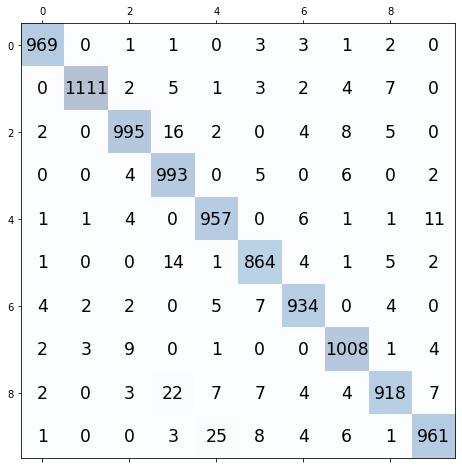

In [92]:
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        y_true.extend(labels.numpy())
        outputs=model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
    cf_matrix = confusion_matrix(y_true, y_pred)
fig,ax = plt.subplots(figsize=(20, 8))
ax.matshow(cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cf_matrix[i, j], va='center', ha='center', size='xx-large')

* The Result got even worse for Relu as an activation function in this specific case it might because of the type of problen this is why sigmoid is performing better.

* Sigmoid gives out between 0 and 1 which gives things in check but relu has range 0 to x which can easily get big and then weights have biases for higher value of activation.

## We can add L2 Regularization to pytorch using weight decay parameter here i have added weight decay to be 0.01

In [93]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)

In [94]:
# Train the model
loss_log = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_log.append(loss.item())

Epoch [1/15], Step [100/938], Loss: 0.1644
Epoch [1/15], Step [200/938], Loss: 0.0776
Epoch [1/15], Step [300/938], Loss: 0.3799
Epoch [1/15], Step [400/938], Loss: 0.3499
Epoch [1/15], Step [500/938], Loss: 0.2709
Epoch [1/15], Step [600/938], Loss: 0.2962
Epoch [1/15], Step [700/938], Loss: 0.4313
Epoch [1/15], Step [800/938], Loss: 0.2822
Epoch [1/15], Step [900/938], Loss: 0.6851
Epoch [2/15], Step [100/938], Loss: 0.4997
Epoch [2/15], Step [200/938], Loss: 0.4062
Epoch [2/15], Step [300/938], Loss: 0.4313
Epoch [2/15], Step [400/938], Loss: 0.2879
Epoch [2/15], Step [500/938], Loss: 0.1662
Epoch [2/15], Step [600/938], Loss: 0.5362
Epoch [2/15], Step [700/938], Loss: 0.2701
Epoch [2/15], Step [800/938], Loss: 0.2152
Epoch [2/15], Step [900/938], Loss: 0.3423
Epoch [3/15], Step [100/938], Loss: 0.2519
Epoch [3/15], Step [200/938], Loss: 0.4430
Epoch [3/15], Step [300/938], Loss: 0.4985
Epoch [3/15], Step [400/938], Loss: 0.3458
Epoch [3/15], Step [500/938], Loss: 0.2547
Epoch [3/15

Accuracy of the network on the 10000 test images: 76.92166666666667 %


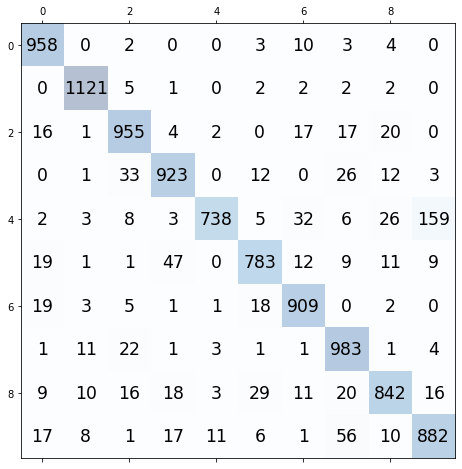

In [95]:
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        y_true.extend(labels.numpy())
        outputs=model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
    cf_matrix = confusion_matrix(y_true, y_pred)
fig,ax = plt.subplots(figsize=(20, 8))
ax.matshow(cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cf_matrix[i, j], va='center', ha='center', size='xx-large')

* Adding a regularization factor of 0.01 we can see the model gets from 74 to 76 this is better than before but it can be better if we try with different learnrate and epoch size.

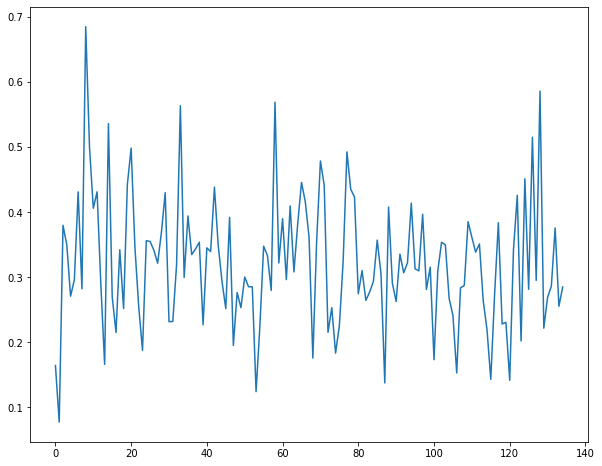

In [96]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)